# Predicting Tax Value for Single Family Homes

by Braeden Wright
03-30-2022

## Project Goal

- Find the key drivers of property value for single family properties and construct an ML Regression model that will predict property tax assessed values (tax_value) for those homes.


## Initial Questions

- Does more square footage have a linear relation to  tax value, as I suspect it to?
- Would the year the house was built positively or negatively affect tax value?
- Will the geographical location(fips) be useful, or does it skew the data?

## Data Dictionary


   #### Feature   ----->     Discription
   -----------------------------
   - tax_value -----> The total tax assessed value of the parcel. Also our y variable
   - year_built ----> The Year the principal residence was built 
   - fips ----------> Federal Information Processing Standard code -  see https://en.wikipedia.org/wiki/FIPS_county_code for more details
   - sqr_feet ------> Calculated total finished living area of the home 
   - bedrooms ------> Number of bedrooms in home 
   - bathrooms -----> Number of bathrooms in home 

# Imports

In [1]:
# Foundation
import pandas as pd
import numpy as np
from scipy import math

# Visuals
import matplotlib.pyplot as plt
import seaborn as sns


# Metric and Modeling Tools
import sklearn.linear_model
import sklearn.feature_selection
import sklearn.preprocessing
from sklearn.linear_model import LogisticRegression

# Custom
import wrangle_prep as wp
import explore as ep


# Required Data
df = wp.wrangle_zillow()
df.head(3)

Reading cleaned data from csv file...


,bedrooms,bathrooms,sqr_feet,tax_value,year_built,fips
0,4.0,2.0,3633.0,296425.0,2005,6037
1,3.0,2.0,1222.0,290492.0,1951,6037
2,3.0,2.5,1821.0,537949.0,2013,6059


- In addition to pulling the data, the wrangle_zillow function also cleans the data and removes outliers that I found reduced the efficiency of the models. (For more details on how I came to these conclusions, see the zillow_workbook.ipynb)
- I pulled only the features I concluded would best benefit the model, and quckly make sure they are all the proper data types.

In [3]:
df.year_built = df.year_built.astype(object)
df.fips = df.fips.astype(object)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1355481 entries, 0 to 1355480
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   bedrooms    1355481 non-null  float64
 1   bathrooms   1355481 non-null  float64
 2   sqr_feet    1355481 non-null  float64
 3   tax_value   1355481 non-null  float64
 4   year_built  1355481 non-null  object 
 5   fips        1355481 non-null  object 
dtypes: float64(4), object(2)
memory usage: 62.0+ MB


### Data Splits

In [4]:
# Data Split
train, validate, test = wp.split_data(df)

train <> (759068, 6)
validate <> (325316, 6)
test <> (271097, 6)


In [5]:
# Variables for models

x_train = train.drop(columns=['tax_value'])
y_train = train.tax_value

x_validate = validate.drop(columns=['tax_value'])
y_validate = validate.tax_value

x_test = test.drop(columns=['tax_value'])
y_test = test.tax_value

In [6]:
# Scaling

# Make it
scaler = sklearn.preprocessing.MinMaxScaler()

# Fit it
scaler.fit(x_train)

# Use it
x_train_scaled = scaler.transform(x_train)
x_validate_scaled = scaler.transform(x_validate)
x_test_scaled = scaler.transform(x_test)

# Exploration

### I started by comparing my features against each other with a few methods
- Heatmap of continuous features
- RFE rankings
- K Best

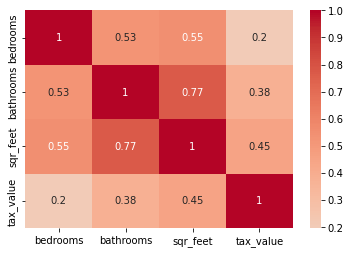

In [7]:
# Heatmap
sns.heatmap(train.corr(), cmap='coolwarm', center=0, annot=True)
plt.show()

In [8]:
# RFE Ranking
ep.rfe_feature_rankings(x_train_scaled, x_train, y_train, 1)

,Var,Rank
2,sqr_feet,1
1,bathrooms,2
0,bedrooms,3
3,year_built,4
4,fips,5


In [11]:
# KBest
kbest = sklearn.feature_selection.SelectKBest(sklearn.feature_selection.f_regression, k=2)
kbest.fit(x_train_scaled, y_train)
kbest_results = pd.DataFrame(dict(p=kbest.pvalues_, f=kbest.scores_), index=x_train.columns)
kbest_results

,p,f
bedrooms,0.0,30304.193347
bathrooms,0.0,129406.449924
sqr_feet,0.0,195663.134174
year_built,0.0,77177.449390
fips,0.0,9086.959230


### These three test's seem to confirm that that the square footage of a home will more than likely indicate correlation.

### I used this going forward to explore other features

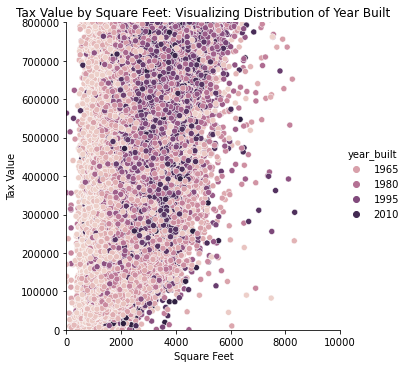

In [20]:
# Distribution of Year Home was Built
sns.relplot(x='sqr_feet', y='tax_value', data=train, hue='year_built').set(xlim=(0,10000),ylim=(0,800000))
plt.title('Tax Value by Square Feet: Visualizing Distribution of Year Built')
plt.xlabel('Square Feet')
plt.ylabel('Tax Value')
plt.show()

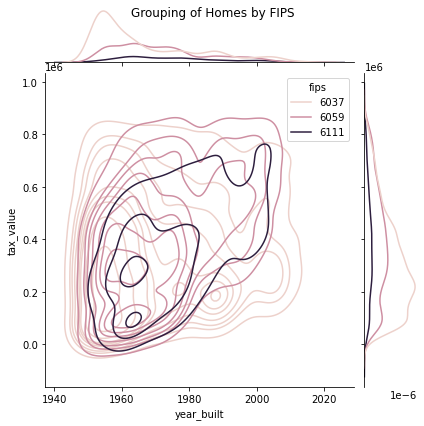

In [27]:
# sample of the data
sample = train.sample(10000)

sns.jointplot('year_built', 'tax_value', data=sample, hue='fips', kind='kde')
plt.suptitle('Grouping of Homes by FIPS')
plt.show()

- Originally when I looked at the data, I noticed that a majority of the homes built before the year 1950 were from LA County (fips code 6037). This skewed the model slightly to favor homes with that fips code, so for the final draft I narrowed my data to homes built later than 1950 so that the different fips locations were more evenly distributed.  This lead to  small improvements in the model.

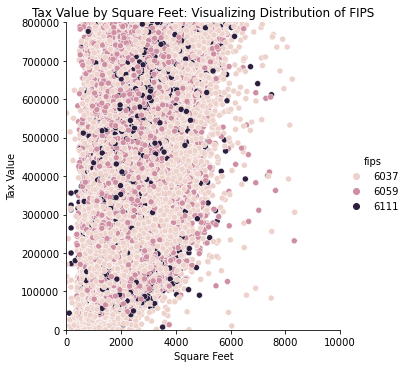

In [19]:
# FIPS Distribution
sns.relplot(x='sqr_feet', y='tax_value', data=train, hue='fips').set(xlim=(0,10000),ylim=(0,800000))
plt.title('Tax Value by Square Feet: Visualizing Distribution of FIPS')
plt.xlabel('Square Feet')
plt.ylabel('Tax Value')
plt.show()

- LA County(6037) still leads in numbers, but Orange County(6059) and Ventura County(6111) both tend to have higher tax values.  
--------------------------------------
### Based on the exploration and visualizations of the data, we can say:


   - Does more square footage have a linear relation to tax value, as I suspect it to?
   #### Yes, square footage is one of our best indicators for tax value and will be a useful feature for modeling
   ----
   - Would the year the house was built positively or negatively affect tax value?
   #### While the tax value of homes built in the same year can vary, homes built more recently tend to have higher tex rates
   ----
   - Will the geographical location(fips) be useful, or does it skew the data?
   #### FIPS was useful for filtering the data and removing outliers, and  it's confirmed that some FIPS can lean towards a higher tax value than others
